This file is to analyze the results and save them


### import and define

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../mypkg'))
if module_path not in sys.path:
    sys.path.append(module_path)

#### Other pkgs

In [2]:
from tqdm import trange, tqdm

import torch
import umap
import torch.nn as nn 
import torch.nn.functional as F 
from sbi import utils as sutils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from torch.distributions.multivariate_normal import MultivariateNormal

import numpy as np
import xarray as xr
from easydict import EasyDict as edict
from collections import defaultdict as ddict
from pathlib import Path
import pickle
import scipy

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json
from functools import partial

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["savefig.bbox"] = "tight"

#### My own pkgs

In [3]:
import importlib

from utils.misc import mag2db, meg_psd2spatialfeature, save_pkl_dict2folder, load_pkl_folder2dict, geodesic_dist
from utils.standardize import stdz_psd, stdz_vec, minmax_vec, psd_2tr
from utils.brain_plot import U2BrainVec, reorderU 
from utils.reparam import theta_raw_2out, normcdf_np, normcdf_torch, logistic_np, logistic_torch
from utils.stable import paras_table_check
from sgm.sgm import SGM
from spectrome import Brain, path, functions
from features.psm import obt_psm_fs, obt_psm_raw
from constants import RES_ROOT, FIG_ROOT, DAT_ROOT
from models.embedding_nets import SummaryNet
from sgm.data_gen import simulator_data

In [4]:
import utils.misc
importlib.reload(utils.misc)

<module 'utils.misc' from '/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/utils/misc.py'>

In [5]:
#torch.set_default_tensor_type(torch.DoubleTensor)

### Load real data PSD and brain

#### PSD and connectome

In [6]:
# Load data
ind_psd_xr = xr.open_dataarray(DAT_ROOT/'individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
FREQS = ind_psd_xr["frequencies"].values
ind_conn_xr = xr.open_dataarray(DAT_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values

#### Set up Parameters

In [7]:
# some constant parameters for this file
paras = edict()
#bnds = ((5.0,30.0), (5.0,200.0), (0.1,1.0), (5, 20), (0.001,0.7), (0.001,2.0), (5.0,30.0))
#Bounds for taue, taui, alpha, speed, gei, gii, tauC
# (0.001,0.7), (0.001,2.0) when considering stable checking.
# (0.001,0.5), (0.001,1.5) as safe (narrower) bounds

# taue, taui, tauC, speed, alpha, gii, gei
paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.names = ["Taue", "Taui", "TauC", "Speed", "alpha", "gii", "gei"]

paras.num_prior_sps = int(1e5)
paras.noise_sd = 1.6
paras.den_est = "nsf"
paras.is_embed = False

paras.prior_sd = 10

In [34]:
# paras  for this file
_paras = edict()
_paras.filss = []
_folder_path = f"./new_bds[0-9]*_reparam{paras.num_prior_sps:.0f}" +\
                   f"_sd{paras.noise_sd*100:.0f}" +\
                   f"_denest{paras.den_est}" +\
                   f"_embed{paras.is_embed}"
fils = list(RES_ROOT.glob(_folder_path))
_paras.fils = sorted(fils, key=lambda x: int(x.stem.split("bds")[1].split("_")[0]))

_paras.name_order = ['taue','taui','tauG','speed','alpha','gii','gei']
_paras.name_order_latex = [r'$\tau_e$',r'$\tau_i$',r'$\tau_G$',r'$v$',r'$\alpha$',r'$g_{ii}$',r'$g_{ei}$']

# plot setting
_paras.plot_sets = edict()
_paras.plot_sets.col = ["dodgerblue", "coral"]
_paras.plot_sets.alpha = 0.8
_paras.plot_sets.marker = ["o", "h"]

_paras.metd = edict()
_paras.metd.SBI = "SBI"
_paras.metd.anl = "Annealing"

In [9]:
prior = MultivariateNormal(loc=torch.zeros(7), covariance_matrix=torch.eye(7)*(paras.prior_sd**2))

In [10]:
# obtain the brain
brain = Brain.Brain()
brain.add_connectome(DAT_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()
sgmmodel = SGM(brain.reducedConnectome, brain.distance_matrix, FREQS)

In [11]:
meg_psd_curve = np.median([np.mean(psd_2tr(ind_psd[:, :, ix]), axis=0) for ix in range(36)], axis=0)
#meg_psd_curve = np.mean([psd_2tr(ind_psd[:, :, ix]).mean(axis=0) for ix in range(36)], axis=0)
meg_psd_roi_sub = np.array([psd_2tr(ind_psd[:, :, ix]) for ix in range(36)])

# the estimated spatial feature from MEG
meg_sps = []
meg_sp_raws = []
for ix in trange(36):
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
    
    curMEGSP, curMEGSPRaw = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, ix], FREQS)
    meg_sps.append(curMEGSP)
    meg_sp_raws.append(curMEGSPRaw.sum(axis=1))

meg_sps = np.array(meg_sps)
meg_sp_raws = np.array(meg_sp_raws)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 56.68it/s]


#### Some fns

In [12]:
_map_fn_torch = partial(logistic_torch, k=0.1)
_theta_raw_2out = partial(theta_raw_2out, map_fn=partial(logistic_np, k=0.1))

In [13]:
def _filter_unstable(theta_raw, prior_bds, x=None):
    """This fn is to remove unstable SGM parameters
        args: theta_raw: parameters: num of sps x dim
                order: ['Taue', 'Taui', 'TauC', 'Speed', 'alpha', 'gii', 'gei']
    """
    theta = _theta_raw_2out(theta_raw.numpy(), prior_bds)
    stable_idxs = paras_table_check(theta)
    
    # keep stable sps only
    theta_raw_stable = theta_raw[stable_idxs==0]
    if x is not None:
        x_stable = x[stable_idxs==0]
        return theta_raw_stable, x_stable
    else:
        return theta_raw_stable

### Analysis for one setting

In [14]:
cur_ress = [load_pkl_folder2dict(cur_fil, ["*_raw", "posterior"], verbose=False) 
            for cur_fil in tqdm(_paras.fils)
           ]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


In [15]:
result = ddict(list)
for cur_res in tqdm(cur_ress):
    est_psds = []
    est_FCs = []
    est_sps = []
    
    post_psd_sps = []
    post_sp_sps = []
    for post_psd in cur_res.fb_post_res:
        est_psd = np.mean(post_psd[:, :-68], axis=0)
        est_psd = est_psd.reshape(68, 40)
        est_sp = np.mean(post_psd[:, -68:], axis=0)
        
        est_psds.append(est_psd)
        est_sps.append(est_sp)
        est_FCs.append(np.corrcoef(est_psd))
    
        post_psd_sps.append(post_psd[:, :-68].reshape(-1, 68, 40))
        post_sp_sps.append(post_psd[:, -68:].reshape(-1, 68))
        
    # single corr
    sgm_psd_curve_fb = np.median(np.mean(np.array(est_psds), axis=1), axis=0)
    #sgm_psd_curve_fb = np.array(est_psds).mean(axis=1).mean(axis=0)
    corr = scipy.stats.pearsonr(stdz_vec(meg_psd_curve), stdz_vec(sgm_psd_curve_fb))[0]
    #print(f"Corr is {corr:.3f}")
    
    # Corrs for PSD and spatial features for each subject
    sgm_psd_roi_sub_fb = np.array(est_psds)
    corrs_roi_sub_fb = []
    for ix in range(meg_psd_roi_sub.shape[0]):
        cur_meg = meg_psd_roi_sub[ix]
        cur_sgm = sgm_psd_roi_sub_fb[ix]
        corrs_roi_sub_fb.append(np.mean([scipy.stats.pearsonr(cur_meg[iy], cur_sgm[iy])[0] for iy in range(68)]))
    corrs_roi_sub_fb = np.array(corrs_roi_sub_fb)
    
    sgm_sp_sub = np.array(est_sps)
    corrs_sp = []
    for ix in range(meg_sps.shape[0]):
        cur_meg = meg_sps[ix]
        cur_sgm = cur_res.raw_sp[ix]
        #cur_sgm = est_sps[ix]
        corrs_sp.append(np.dot(cur_sgm/np.linalg.norm(cur_sgm), cur_meg))
    
    # geodesic dist
    geo_dists = [geodesic_dist(np.corrcoef(meg_psd_roi_sub[iz]), est_FCs[iz]) for iz in range(36)]
    
    result["sgm_psd_curs"].append(sgm_psd_curve_fb)
    result["corr"].append(corr)
    result["corrs_sp"].append(corrs_sp)
    result["corrs_roi_sub"].append(corrs_roi_sub_fb)
    result["geo_dists"].append(geo_dists)
    result["post_psd_spss"].append(post_psd_sps)
    result["post_sp_spss"].append(post_sp_sps)
result = edict(result)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.15it/s]


In [16]:
corrs_sub = np.median(result.corrs_roi_sub, axis=1)
sel_idx = np.argmin(np.abs(corrs_sub-np.mean(corrs_sub)))

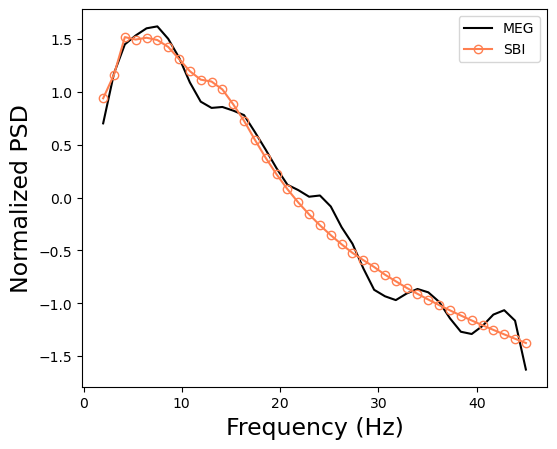

In [17]:
plt.figure(figsize=[6, 5], dpi=100)
plt.plot(FREQS, stdz_vec(meg_psd_curve), linestyle = '-',marker = '',
         fillstyle = 'none',color = 'k', 
         label = "MEG")
#plt.plot(FREQS, stdz_vec(np.mean(result.sgm_psd_curs, axis=0)), linestyle = '-',marker="o",
plt.plot(FREQS, stdz_vec(result.sgm_psd_curs[sel_idx]), linestyle = '-',marker="o",
         fillstyle = 'none',color = _paras.plot_sets.col[1], 
         label = "SBI")
plt.xlabel('Frequency (Hz)', fontsize = 17)
plt.ylabel('Normalized PSD', fontsize = 17)
plt.legend()


### Parul results

In [18]:
anl_res = pd.read_csv(DAT_ROOT/"./parul_stable_results.csv")

# clean the col name
new_cols = [col.split(" ")[-1].strip() for col in anl_res.columns]
anl_res.columns = new_cols

In [19]:
# taue, taui, tauC, speed, alpha, gii, gei
para_nams = ["taue", "taui", "tauC", "speed", "alpha", "gii", "gei"]
#para_nams = paras.name_order
def res_2vec(ix=0):
    vec = np.array([anl_res[nam][ix] for nam in para_nams])
    vec[:3] = vec[:3]/1000
    return vec

In [20]:
anl_sgmPSDs = []
anl_sgmSPs = []
for ix in trange(36):
    curParas = res_2vec(ix)
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
        # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
        
    curSgmModel = SGM(curBrain.reducedConnectome, curBrain.distance_matrix, FREQS)
    curPSD, curSPs = curSgmModel.run_local_coupling_forward(curParas)
    curPSD = curPSD[:68, :]
    curPSD = psd_2tr(curPSD)
        
    anl_sgmPSDs.append(curPSD)
    anl_sgmSPs.append(curSPs.sum(axis=1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:39<00:00,  1.11s/it]


(36, 68, 40)

### Plots

In [21]:
sel_res =  load_pkl_folder2dict(_paras.fils[sel_idx], ["*_raw"], verbose=False)

#### Anl vs SBI

In [22]:
anl_PSD = np.median(np.mean(np.array(anl_sgmPSDs), axis=1), axis=0)

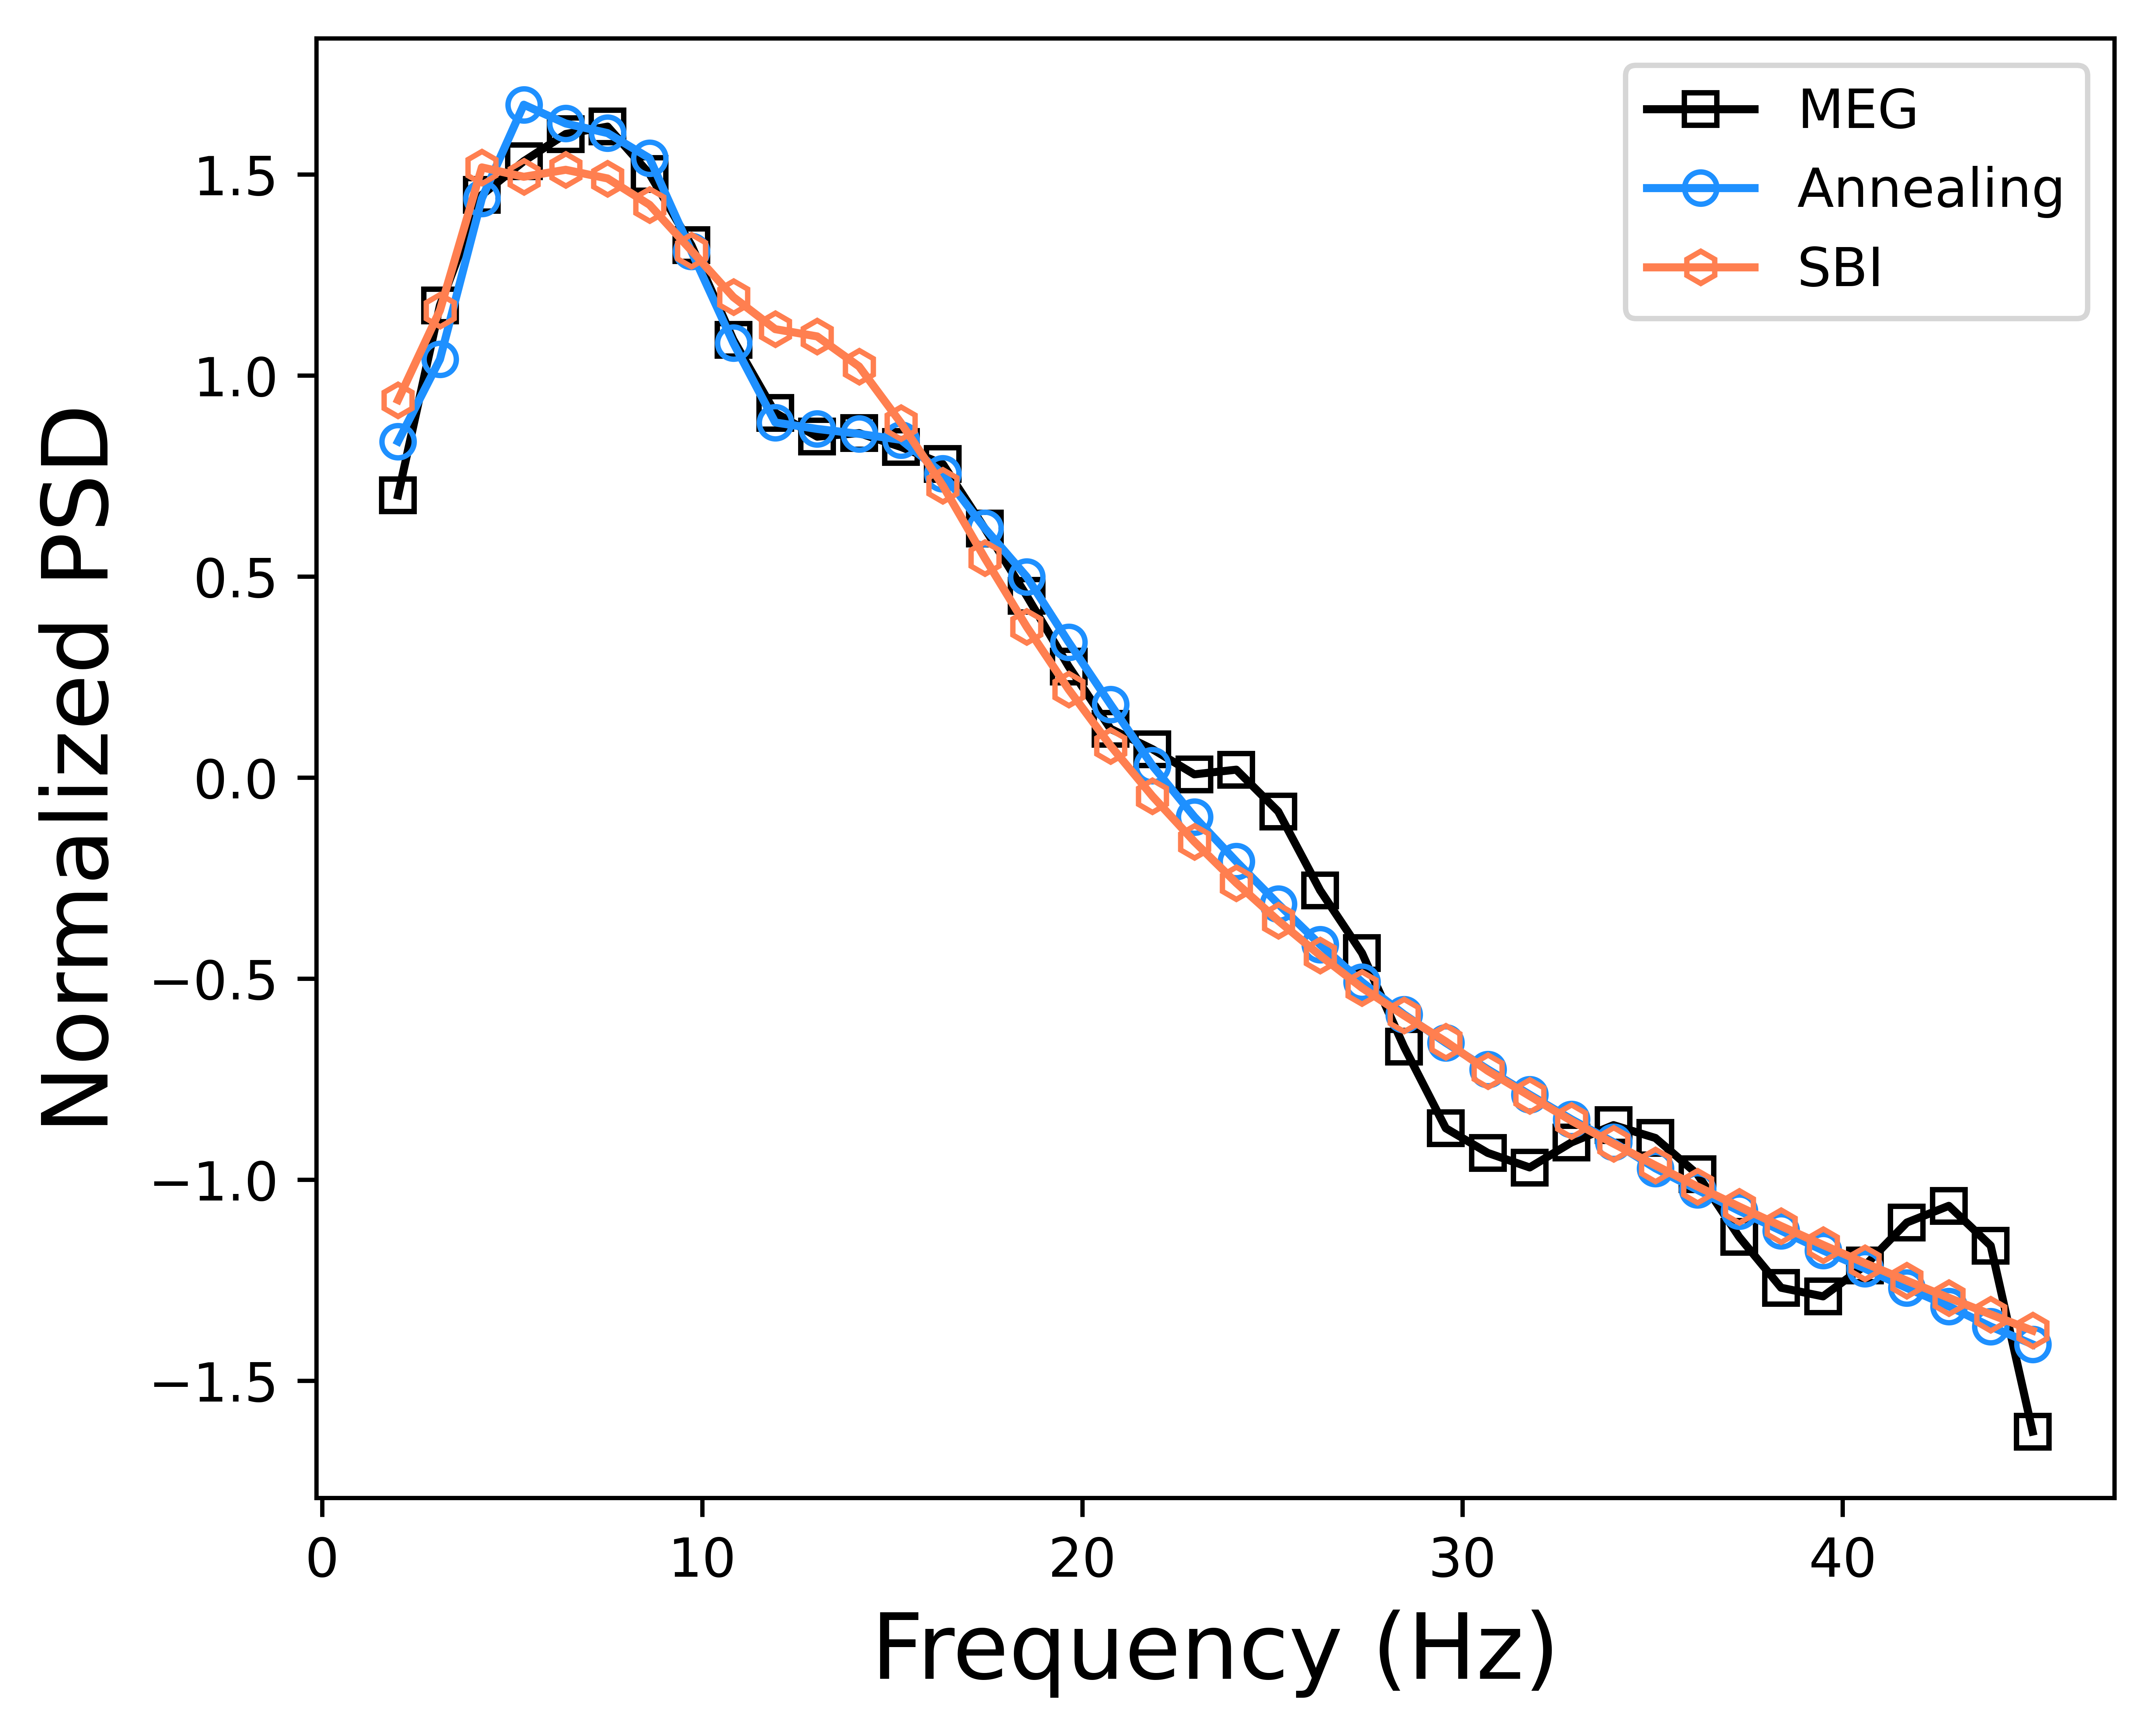

In [43]:
plt.figure(figsize=[6, 5], dpi=1000)
plt.plot(FREQS, stdz_vec(meg_psd_curve), 
         linestyle = '-',marker = 's',
         fillstyle = 'none',color = 'k', 
         label = "MEG")
plt.plot(FREQS, stdz_vec(anl_PSD), 
         linestyle = '-', marker=_paras.plot_sets.marker[0],
         fillstyle = 'none',color = _paras.plot_sets.col[0], 
         label = _paras.metd.anl)
plt.plot(FREQS, stdz_vec(result.sgm_psd_curs[sel_idx]), 
         linestyle = '-',marker=_paras.plot_sets.marker[1],
         fillstyle = 'none',color = _paras.plot_sets.col[1], 
         label = _paras.metd.SBI)
plt.xlabel('Frequency (Hz)', fontsize = 17)
plt.ylabel('Normalized PSD', fontsize = 17)
plt.legend()

plt.savefig(FIG_ROOT/"newbds_PSD_compare.jpg")

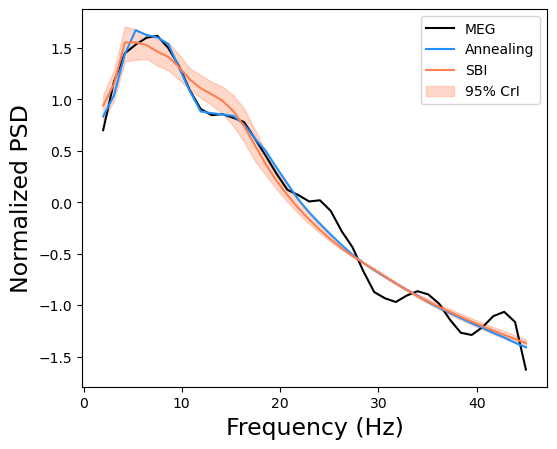

In [115]:
# 190 is to make sure all the MEG data have the same num of spss
cur_post_psd_clean = np.array([ix[:190] for ix in result.post_psd_spss[sel_idx]])

post_psd_curs = []
for cur_sps in np.transpose(cur_post_psd_clean, (1, 0, 2, 3)):
    #cur_psd_cur = np.median(np.mean(cur_sps, axis=1), axis=0)
    cur_psd_cur = stdz_vec(np.median(np.mean(cur_sps, axis=1), axis=0))
    post_psd_curs.append(cur_psd_cur)

post_psd_curs = np.array(post_psd_curs)

lows, ups =  np.quantile(post_psd_curs, [0.025, 0.975], axis=0)
#lows, ups = stdz_vec(lows), stdz_vec(ups)

plt.figure(figsize=[6, 5], dpi=100)
plt.plot(FREQS, stdz_vec(meg_psd_curve), 
         linestyle = '-',marker = '',
         fillstyle = 'none',color = 'k', 
         label = "MEG")
plt.plot(FREQS, stdz_vec(anl_PSD), 
         linestyle = '-', #marker=_paras.plot_sets.marker[0],
         fillstyle = 'none',color = _paras.plot_sets.col[0], 
         label = _paras.metd.anl)
plt.plot(FREQS, stdz_vec(np.mean(post_psd_curs, axis=0)),
         linestyle = '-',#marker=_paras.plot_sets.marker[1],
         fillstyle = 'none',color = _paras.plot_sets.col[1], 
         label = _paras.metd.SBI)
plt.fill_between(FREQS, lows, ups, color=_paras.plot_sets.col[1], alpha=0.3, label="95% CrI")
plt.xlabel('Frequency (Hz)', fontsize = 17)
plt.ylabel('Normalized PSD', fontsize = 17)
plt.legend()

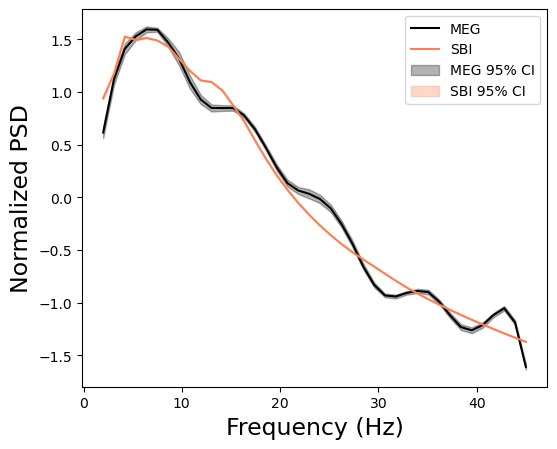

In [116]:
meg_region_psds = np.median(meg_psd_roi_sub, axis=0)
meg_region_psds = np.array([stdz_vec(cur_psd) for cur_psd in meg_region_psds])
meg_mean = meg_region_psds.mean(axis=0)
meg_std = meg_region_psds.std(axis=0)
meg_low = meg_mean - 1.96*meg_std/np.sqrt(68)
meg_up = meg_mean + 1.96*meg_std/np.sqrt(68)

anl_region_psds = np.median(anl_sgmPSDs, axis=0)
anl_region_psds = np.array([stdz_vec(cur_psd) for cur_psd in anl_region_psds])
anl_mean = anl_region_psds.mean(axis=0)
anl_std = anl_region_psds.std(axis=0)
anl_low = anl_mean - 1.96*anl_std/np.sqrt(68)
anl_up = anl_mean + 1.96*anl_std/np.sqrt(68)

sbi_region_psds = np.median(cur_post_psd_clean.mean(axis=1), axis=0)
sbi_region_psds = np.array([stdz_vec(cur_psd) for cur_psd in sbi_region_psds])
sbi_mean = sbi_region_psds.mean(axis=0)
sbi_std = sbi_region_psds.std(axis=0)
sbi_low = sbi_mean - 1.96*sbi_std/np.sqrt(68)
sbi_up = sbi_mean + 1.96*sbi_std/np.sqrt(68)

plt.figure(figsize=[6, 5], dpi=100)
plt.plot(FREQS, meg_mean,
         linestyle = '-',marker = '',
         fillstyle = 'none',color = 'k', 
         label = "MEG")
plt.fill_between(FREQS, meg_low, meg_up, color="black", alpha=0.3, label="MEG 95% CI")
#plt.plot(FREQS, anl_mean,
#         linestyle = '-', #marker=_paras.plot_sets.marker[0],
#         fillstyle = 'none',color = _paras.plot_sets.col[0], 
#         label = _paras.metd.anl)
#plt.fill_between(FREQS, anl_low, anl_up, color=_paras.plot_sets.col[0], alpha=0.3, label="Annealing 95% CI")
plt.plot(FREQS, sbi_mean,
         linestyle = '-',#marker=_paras.plot_sets.marker[1],
         fillstyle = 'none',color = _paras.plot_sets.col[1], 
         label = _paras.metd.SBI)
plt.fill_between(FREQS, sbi_low, sbi_up, color=_paras.plot_sets.col[1], alpha=0.3, label="SBI 95% CI")
plt.xlabel('Frequency (Hz)', fontsize = 17)
plt.ylabel('Normalized PSD', fontsize = 17)
plt.legend()

In [38]:
anl_SP_corrs = []
for mv, ov in zip(anl_sgmSPs, meg_sps):
    anl_SP_corrs.append(np.dot(mv/np.linalg.norm(mv), ov))
anl_SP_corrs = np.array(anl_SP_corrs)

anl_PSD_corrs = []
for ix in range(meg_psd_roi_sub.shape[0]):
    curMEG = meg_psd_roi_sub[ix]
    curSGM = anl_sgmPSDs[ix]
    anl_PSD_corrs.append(np.mean([scipy.stats.pearsonr(curMEG[iz], curSGM[iz])[0] for iz in range(68)]))
anl_PSD_corrs = np.array(anl_PSD_corrs)

sbi_SP_corrs = np.array(result.corrs_sp[sel_idx])
sbi_PSD_corrs = np.array(result.corrs_roi_sub[sel_idx])

In [40]:
SP_both = np.array([anl_SP_corrs, sbi_SP_corrs])
PSD_both = np.array([anl_PSD_corrs, sbi_PSD_corrs])

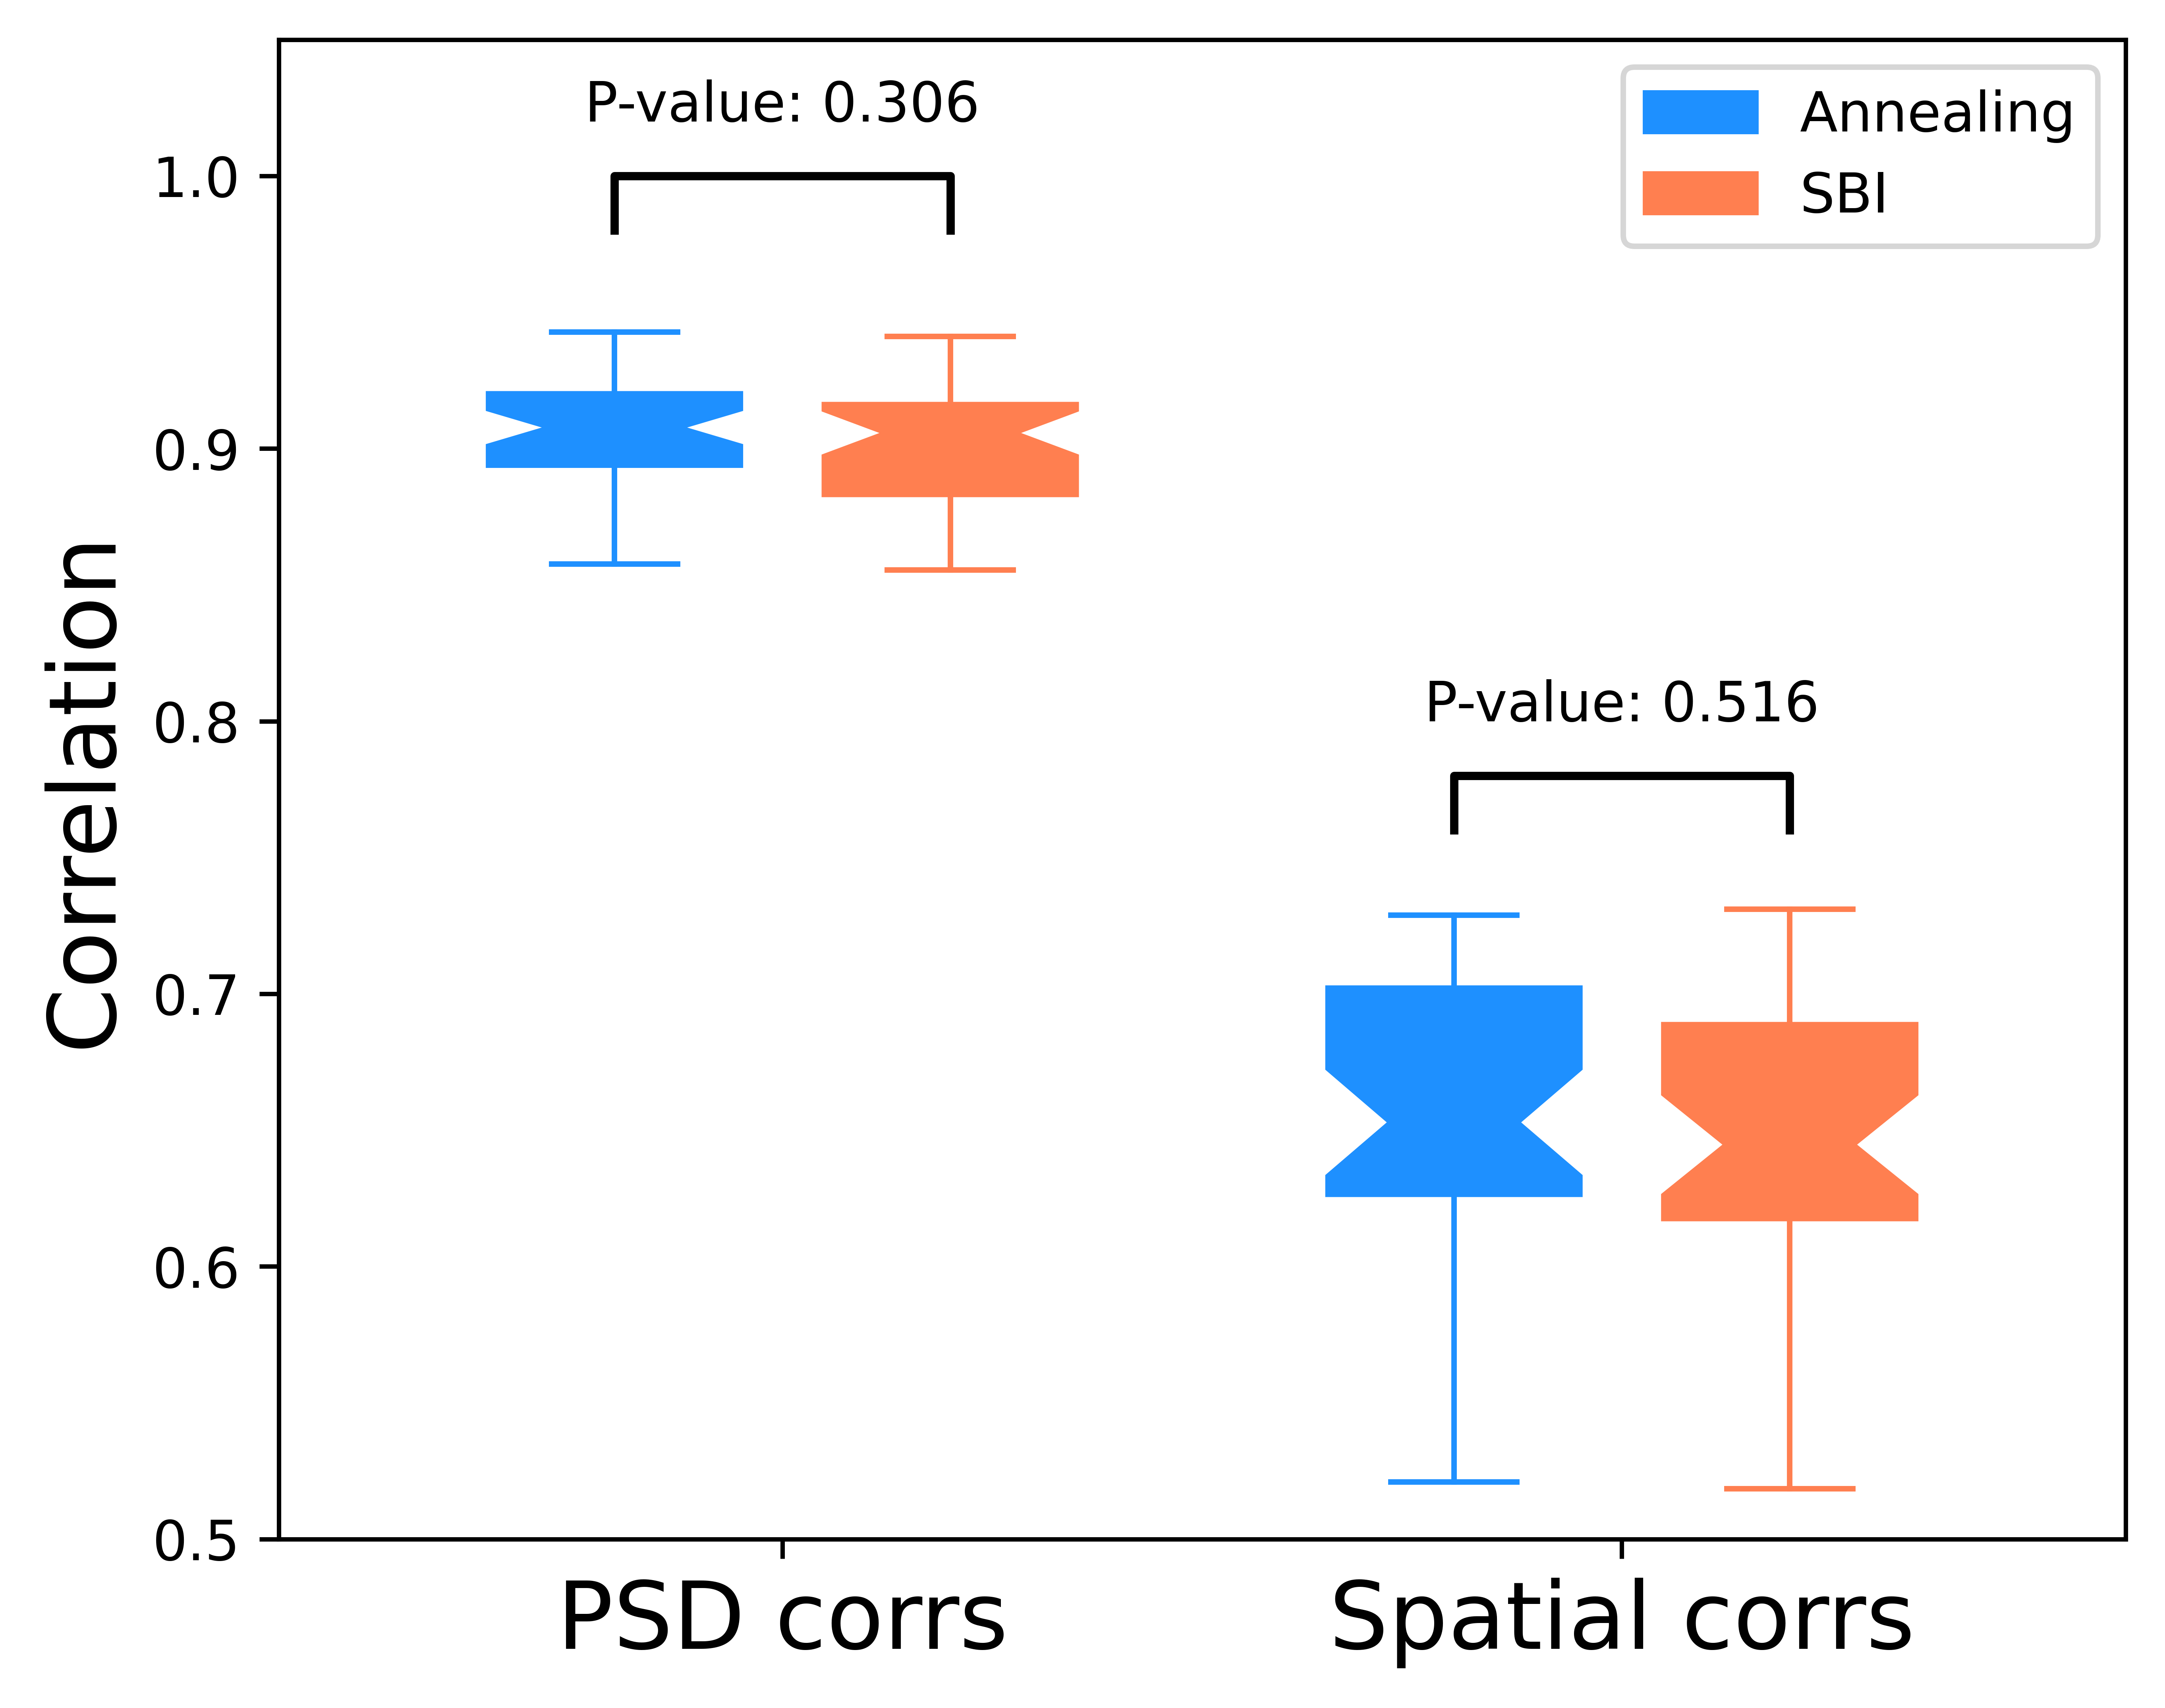

In [64]:
plt.figure(figsize=[6, 5], dpi=1000)
box = plt.boxplot(PSD_both.T[:, 0], positions=[0.4],
                  notch=True, showfliers=False,  patch_artist=True);
for item in ['boxes', 'whiskers',  'medians', 'caps']:
    plt.setp(box[item], color=_paras.plot_sets.col[0])
box1 = box
    
box = plt.boxplot(PSD_both.T[:, 1], positions=[0.6],
                  notch=True, showfliers=False,  patch_artist=True);
for item in ['boxes', 'whiskers',  'medians', 'caps']:
    plt.setp(box[item], color=_paras.plot_sets.col[1])
box2 = box
pv = scipy.stats.ttest_ind(PSD_both[0, :], PSD_both[1, :]).pvalue
dlt = 0.02
base_h = 0.98
plt.plot([0.4, 0.4, 0.6, 0.6], [base_h, base_h+dlt, base_h+dlt, base_h], "-", color="black")
plt.text(0.5, base_h+dlt+0.02, f"P-value: {pv:.3f}", ha="center")
    
box = plt.boxplot(SP_both.T[:, 0], positions=[.9],
                  notch=True, showfliers=False,  patch_artist=True);
for item in ['boxes', 'whiskers',  'medians', 'caps']:
    plt.setp(box[item], color=_paras.plot_sets.col[0])
    
box = plt.boxplot(SP_both.T[:, 1], positions=[1.1],
                  notch=True, showfliers=False,  patch_artist=True);
for item in ['boxes', 'whiskers',  'medians', 'caps']:
    plt.setp(box[item], color=_paras.plot_sets.col[1])
pv = scipy.stats.ttest_ind(SP_both[0, :], SP_both[1, :]).pvalue
dlt = 0.02
base_h = 0.76
plt.plot([0.9, 0.9, 1.1, 1.1], [base_h, base_h+dlt, base_h+dlt, base_h], "-", color="black")
plt.text(1.0, base_h+dlt+0.02, f"P-value: {pv:.3f}", ha="center")

plt.xlim([0.2, 1.3])
plt.ylim([0.5, 1.05])
plt.xticks([0.5, 1], ["PSD corrs", "Spatial corrs"], fontsize=17)
plt.ylabel("Correlation", fontsize=17)
plt.legend([box1["boxes"][0], box2["boxes"][0]], [_paras.metd.anl, _paras.metd.SBI])
plt.savefig(FIG_ROOT/"newbds_corr_boxplots.jpg")

#### Robustness

In [117]:
corrs_sub = np.median(result.corrs_roi_sub, axis=1)
corrs_sub
np.round([np.min(corrs_sub), np.max(corrs_sub)], 4)

array([0.905 , 0.9068])

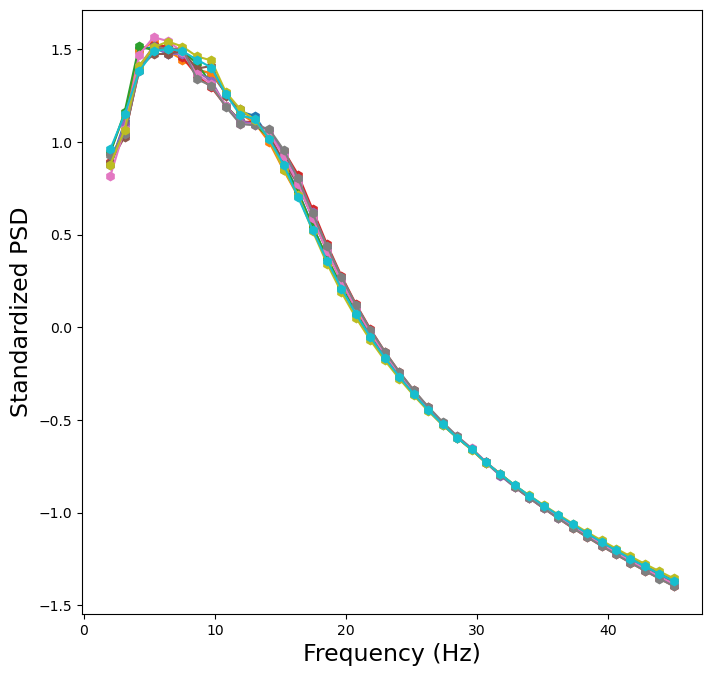

In [118]:
plt.figure(figsize=[8, 8], dpi=100)
for ix in range(10):
    plt.plot(FREQS, stdz_vec(result.sgm_psd_curs[ix]),
    linestyle = '-',marker=_paras.plot_sets.marker[1])
plt.xlabel('Frequency (Hz)', fontsize = 17)
plt.ylabel('Standardized PSD', fontsize = 17)
plt.savefig(FIG_ROOT/"newbds_PSD_all10.jpg", bbox_inches='tight')        

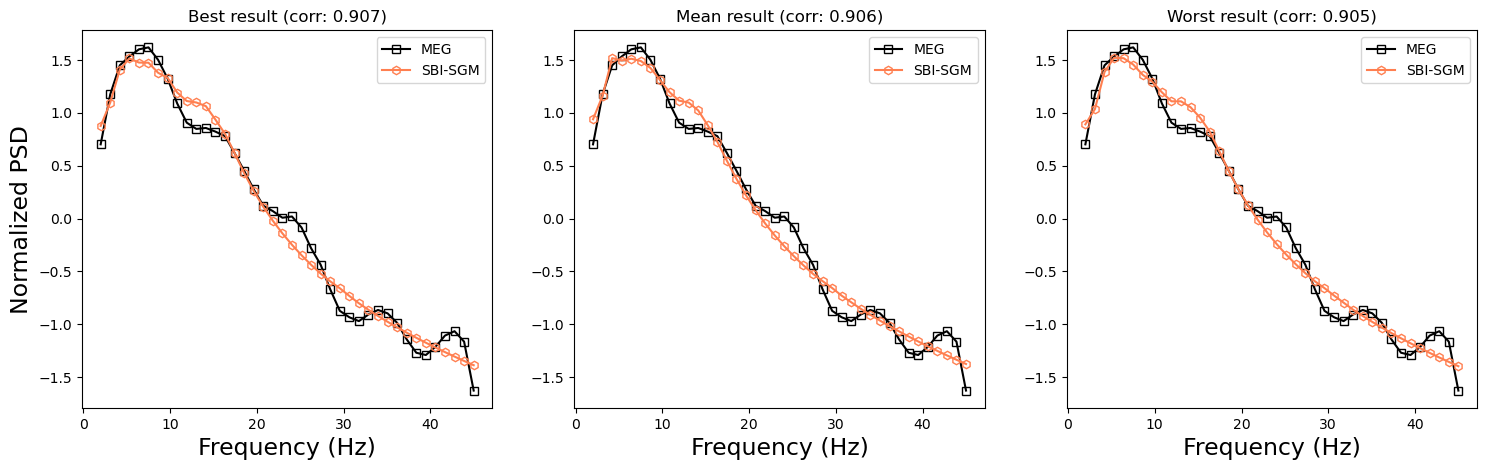

In [241]:
bestId = np.argmax(corrs_sub)
worstId = np.argmin(corrs_sub)
meanId = np.argmin(np.abs(corrs_sub-np.mean(corrs_sub)))
titles = ["Best", "Mean", "Worst"]
plt.figure(figsize=[18, 5], dpi=100)
for ix, curId in enumerate([bestId, meanId, worstId]):
    plt.subplot(1, 3, ix+1)
    plt.title(f"{titles[ix]} result (corr: {corrs_sub[curId]:.3f})")
    plt.plot(FREQS, stdz_vec(meg_psd_curve), linestyle = '-',marker = 's',
         fillstyle = 'none',color = 'k', 
         label = "MEG")
    plt.plot(FREQS, stdz_vec(result.sgm_psd_curs[curId]),
             linestyle = '-',marker=_paras.plot_sets.marker[1],
         fillstyle = 'none',color = _paras.plot_sets.col[1], 
         label = _paras.metd.SBI)
    plt.xlabel('Frequency (Hz)', fontsize = 17)
    plt.legend()
    if ix == 0:
        plt.ylabel('Normalized PSD', fontsize = 17)
plt.savefig(FIG_ROOT/"newbds_PSD_representative.jpg",   bbox_inches='tight')

#### Hist of sps

In [53]:
post_spss_pool = np.concatenate([ix[:9000, :] for ix in sel_res.post_spss])

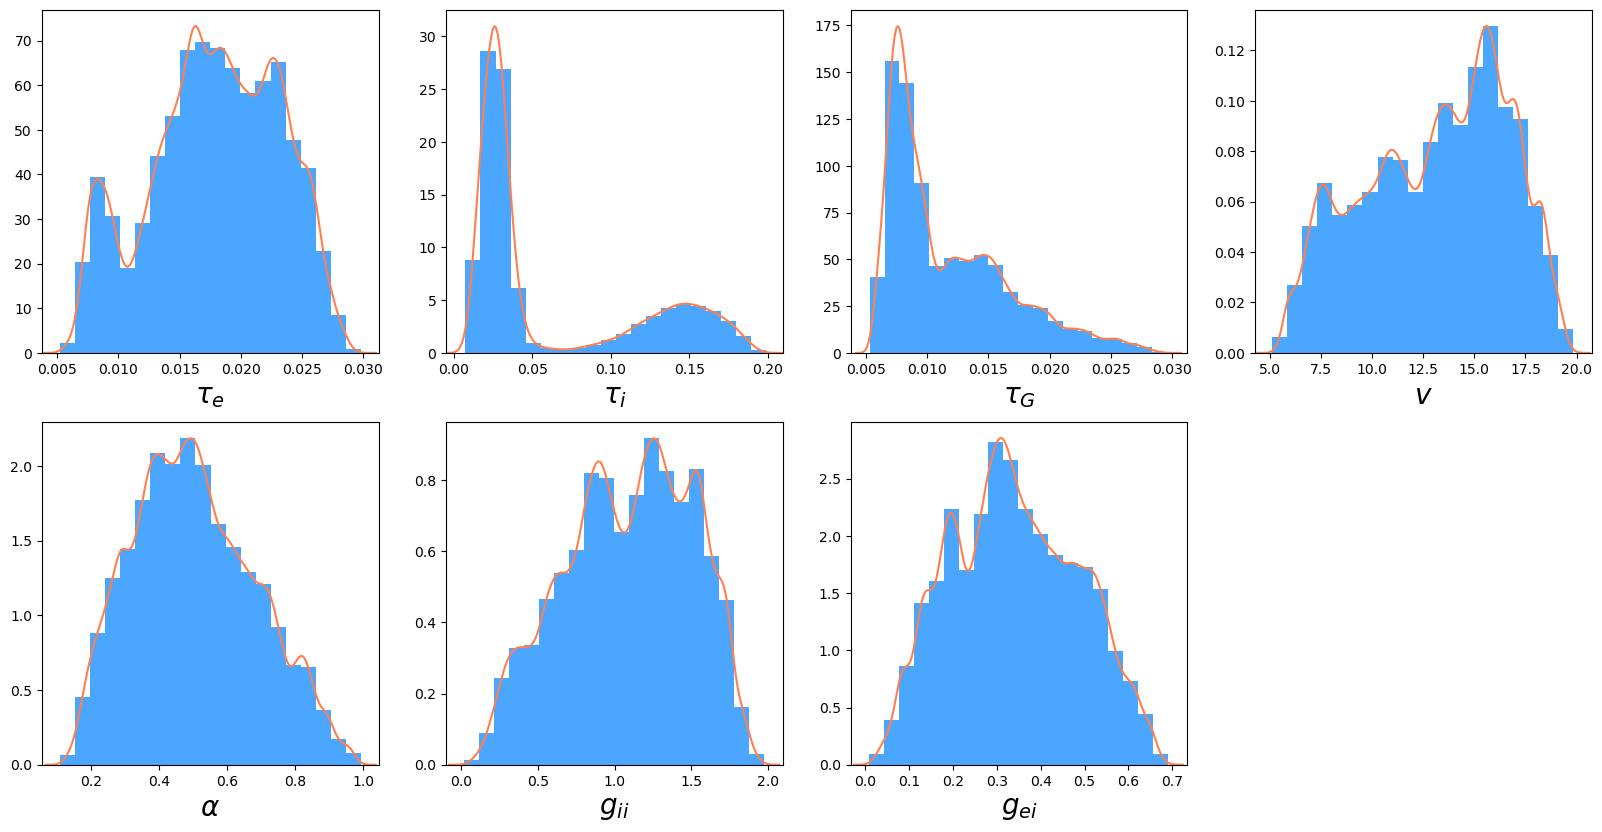

In [352]:
#plt.figure(figsize=[20, 10])
plt.figure(figsize=[20, 10], dpi=100)
for ix in range(7):
    plt.subplot(2, 4, ix+1)
    plt.hist(post_spss_pool[:, ix], bins=20, density=True, 
             alpha=0.8, color=_paras.plot_sets.col[0])
    sns.kdeplot(post_spss_pool[:, ix], color=_paras.plot_sets.col[1])
    adj_fct = np.diff(paras.prior_bds[ix])*np.array([-0.05, 0.05])
    plt.xlim(paras.prior_bds[ix]+adj_fct)
    plt.xlabel(_paras.name_order_latex[ix], fontsize=20)
    #plt.ylim([0, 10])
    plt.ylabel("")
    
plt.savefig(FIG_ROOT/f"newbds_histpara_all.jpg",  bbox_inches='tight')

#### Partial corr

Corr of X and Y when removing the effect of other variables

In [261]:
def lr_resi(Y, X):
    """Return the residual of linear reg with Y ~ 1+X
        args: 
            Y: n 
            X: n x p
    """
    # add slope
    X = np.concatenate([np.ones(X.shape[0]).reshape(-1, 1), X], axis=1)
    beta = np.linalg.inv(X.T @ X) @ X.T @ Y
    residuals = Y - X @ beta
    return residuals

In [275]:
part_corrs_mats = []
for iz in trange(36):
    cur_spss = sel_res.post_spss[iz]
    part_corrs = np.zeros((7, 7))
    for ix in range(7):
        for iy in range(ix+1, 7):
            Y1 = cur_spss[:, ix]
            Y2 = cur_spss[:, iy]
            X = np.delete(cur_spss, [ix, iy], axis=1)
            
            res_Y1 = lr_resi(Y1, X)
            res_Y2 = lr_resi(Y2, X)
            part_cvs = scipy.stats.pearsonr(res_Y1, res_Y2)
            part_corrs[ix, iy] = part_cvs[0]
    part_corrs = part_corrs + part_corrs.T + np.eye(7)
    part_corrs_mats.append(part_corrs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 29.15it/s]


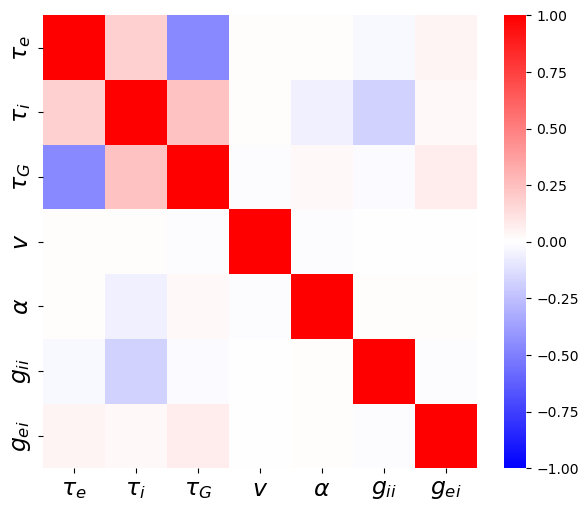

In [341]:
plt.figure(figsize=[7, 6], dpi=100)
sns.heatmap(np.mean(part_corrs_mats, axis=0), vmin=-1, vmax=1, cmap="bwr")
plt.xticks(np.arange(7)+0.5, _paras.name_order_latex, fontsize=17)
plt.yticks(np.arange(7)+0.5, _paras.name_order_latex, fontsize=17);
plt.savefig(FIG_ROOT/f"newbds_partial_corr_all_mean.jpg",  bbox_inches='tight');

#### Examples

In [131]:
sel_sub_idxs = np.argsort(np.abs(sbi_PSD_corrs - np.median(sbi_PSD_corrs)))[:2]
sel_sub_idxs

array([15, 27])

##### KDE

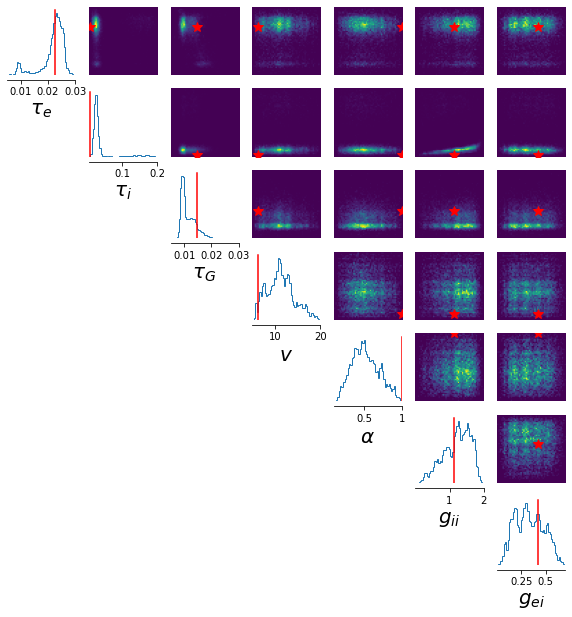

In [137]:
cur_ind_psd = sel_sub_idxs[0]
# taue, taui, tauC, speed, alpha, gii, gei
plt.rc('axes', labelsize=20) 
_ = analysis.pairplot(sel_res.post_spss[cur_ind_psd], 
                      points=res_2vec(cur_ind_psd),
                      points_colors="red",
                      points_offdiag=dict(marker="*", markersize=10),
                      limits=paras.prior_bds, 
                      labels=_paras.name_order_latex,
                      figsize=(10,10), dpi=100)
plt.rc('axes', labelsize=10) 
plt.savefig(FIG_ROOT/f"newbds_postsps_ex{cur_ind_psd}.jpg")

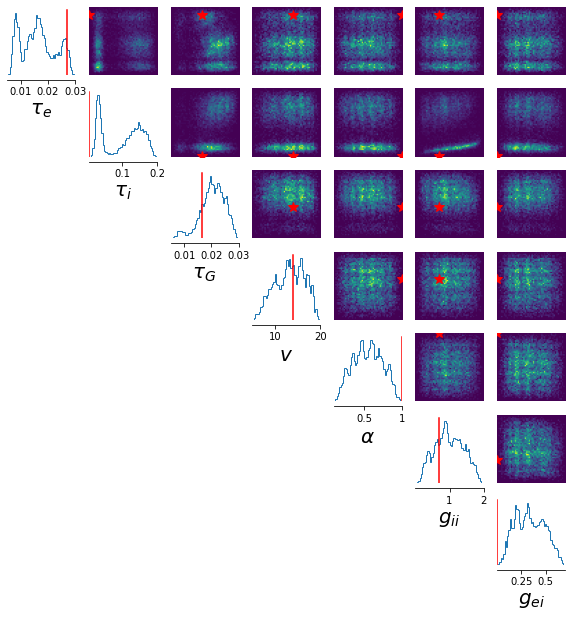

In [138]:
cur_ind_psd = sel_sub_idxs[1]
# taue, taui, tauC, speed, alpha, gii, gei
plt.rc('axes', labelsize=20) 
_ = analysis.pairplot(sel_res.post_spss[cur_ind_psd], 
                      points=res_2vec(cur_ind_psd),
                      points_colors="red",
                      points_offdiag=dict(marker="*", markersize=10),
                      limits=paras.prior_bds, 
                      #upper="scatter",
                      #scatter_offdiag=dict(marker=".", s=5),
                      labels=_paras.name_order_latex,
                      figsize=(10,10), dpi=100)
plt.rc('axes', labelsize=10) 
plt.savefig(FIG_ROOT/f"newbds_postsps_ex{cur_ind_psd}.jpg")

##### PSD curve

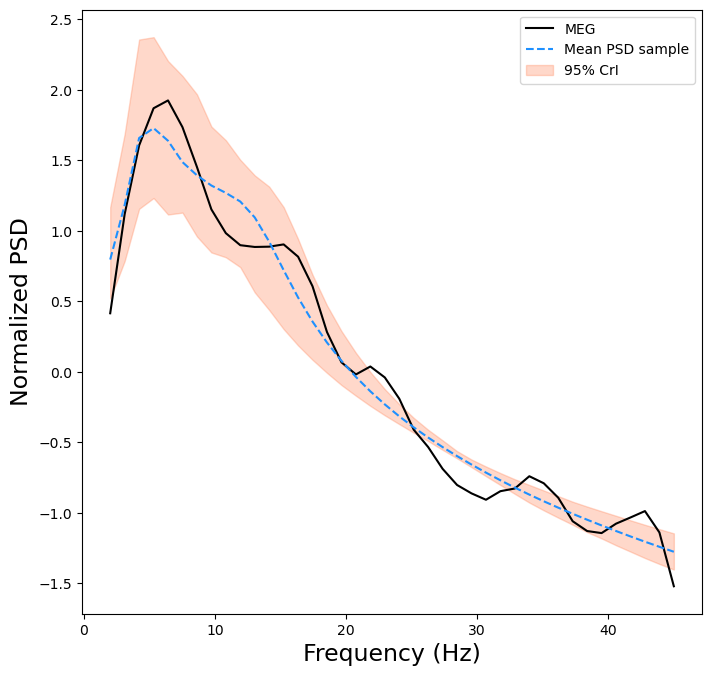

In [188]:
cur_ind_psd = sel_sub_idxs[0]
cur_post_psd_sps = result.post_psd_spss[sel_idx][cur_ind_psd]
obs_meg_psd = stdz_vec(psd_2tr(ind_psd[:, :, cur_ind_psd]).mean(axis=0))

cur_post_psd_m = np.array([stdz_vec((cur_post_psd_sps[ix]).mean(axis=0))  
                        for ix in range(len(cur_post_psd_sps))])

plt.figure(figsize=[8, 8], dpi=100)
lows, ups = np.quantile(cur_post_psd_m, [0.025, 0.975], axis=0)
plt.fill_between(FREQS, lows, ups, color=_paras.plot_sets.col[1], alpha=0.3, label="95% CrI")
plt.plot(FREQS, obs_meg_psd, color='black', label="MEG")
plt.plot(FREQS, np.mean(cur_post_psd_m, axis=0), color=_paras.plot_sets.col[0], linestyle="--", 
         label="Mean PSD sample")
plt.legend()
plt.xlabel('Frequency (Hz)', fontsize = 17)
plt.ylabel('Normalized PSD', fontsize = 17)
plt.savefig(FIG_ROOT/f"newbds_PSDs_ex{cur_ind_psd}.jpg")

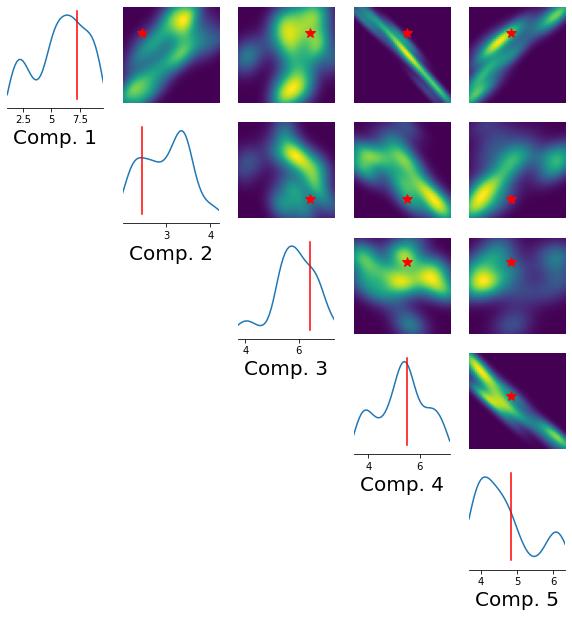

In [191]:
# umap
cur_post_psd_sps_flat = np.array([ix.flatten() for ix in cur_post_psd_sps])
reducer = umap.UMAP(n_components=5, random_state=3)
reducer.fit(cur_post_psd_sps_flat)

red_post_psds = reducer.transform(cur_post_psd_sps_flat)
red_meg_psd =  reducer.transform(psd_2tr(ind_psd[:, :, cur_ind_psd]).flatten().reshape(1, -1))

plt.rc('axes', labelsize=20) 
_ = analysis.pairplot(red_post_psds, 
                  points=red_meg_psd,
                  points_colors="red",
                  points_offdiag=dict(marker="*", markersize=10),
                  upper="kde",
                  diag="kde",
                  labels=[f"Comp. {ix+1}" for ix in range(5)],
                  figsize=(10,10), dpi=100)
plt.rc('axes', labelsize=10) 
plt.savefig(FIG_ROOT/f"newbds_umap_ppc_s_ex{cur_ind_psd}.jpg")

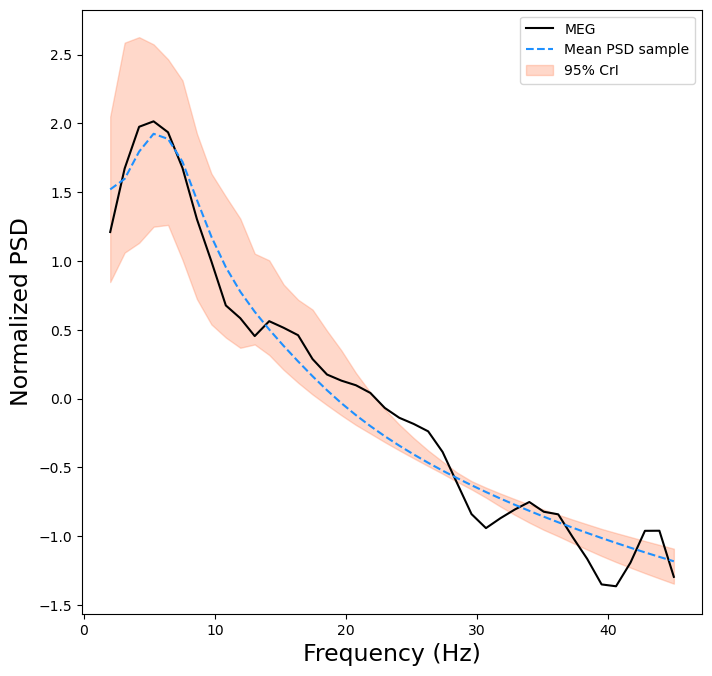

In [192]:
cur_ind_psd = sel_sub_idxs[1]
cur_post_psd_sps = result.post_psd_spss[sel_idx][cur_ind_psd]
obs_meg_psd = stdz_vec(psd_2tr(ind_psd[:, :, cur_ind_psd]).mean(axis=0))

cur_post_psd_m = np.array([stdz_vec((cur_post_psd_sps[ix]).mean(axis=0))  
                        for ix in range(len(cur_post_psd_sps))])

plt.figure(figsize=[8, 8], dpi=100)
lows, ups = np.quantile(cur_post_psd_m, [0.025, 0.975], axis=0)
plt.fill_between(FREQS, lows, ups, color=_paras.plot_sets.col[1], alpha=0.3, label="95% CrI")
plt.plot(FREQS, obs_meg_psd, color='black', label="MEG")
plt.plot(FREQS, np.mean(cur_post_psd_m, axis=0), color=_paras.plot_sets.col[0], linestyle="--", 
         label="Mean PSD sample")
plt.legend()
plt.xlabel('Frequency (Hz)', fontsize = 17)
plt.ylabel('Normalized PSD', fontsize = 17)
plt.savefig(FIG_ROOT/f"newbds_PSDs_ex{cur_ind_psd}.jpg")

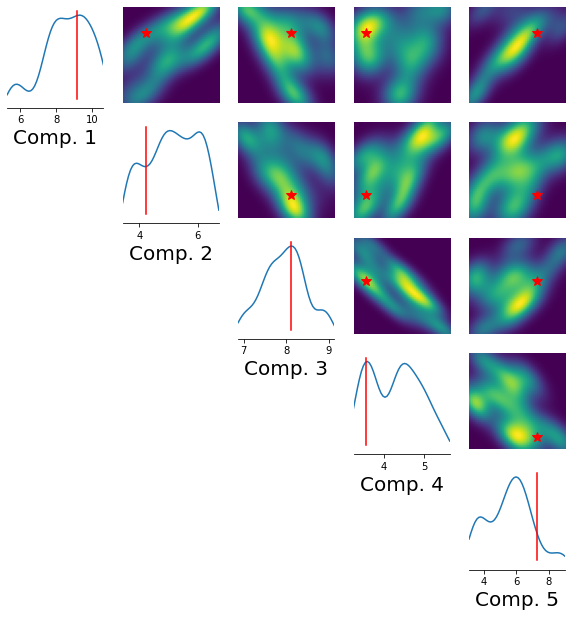

In [193]:
# umap
cur_post_psd_sps_flat = np.array([ix.flatten() for ix in cur_post_psd_sps])
reducer = umap.UMAP(n_components=5, random_state=3)
reducer.fit(cur_post_psd_sps_flat)

red_post_psds = reducer.transform(cur_post_psd_sps_flat)
red_meg_psd =  reducer.transform(psd_2tr(ind_psd[:, :, cur_ind_psd]).flatten().reshape(1, -1))

plt.rc('axes', labelsize=20) 
_ = analysis.pairplot(red_post_psds, 
                  points=red_meg_psd,
                  points_colors="red",
                  points_offdiag=dict(marker="*", markersize=10),
                  upper="kde",
                  diag="kde",
                  labels=[f"Comp. {ix+1}" for ix in range(5)],
                  figsize=(10,10), dpi=100)
plt.rc('axes', labelsize=10) 
plt.savefig(FIG_ROOT/f"newbds_umap_ppc_s_ex{cur_ind_psd}.jpg")

### Save for brain plots

In [326]:
anl_brain_vec = np.median([v/np.linalg.norm(v) for v in anl_sgmSPs], axis=0)

sbi_brain_vec = []
for ix in range(36):
    vec = result.post_sp_spss[sel_idx][ix].mean(axis=0)
    vec = vec/np.linalg.norm(vec)
    sbi_brain_vec.append(vec)
sbi_brain_vec =  np.median(sbi_brain_vec, axis=0)

meg_brain_vec = np.median([v/np.linalg.norm(v) for v in meg_sp_raws], axis=0)

np.savetxt(RES_ROOT/f"./newbds_sbi_sp_Brain_vec.txt", sbi_brain_vec) 
np.savetxt(RES_ROOT/f"./newbds_anl_sp_Brain_vec.txt", anl_brain_vec) 
np.savetxt(RES_ROOT/f"./newbds_meg_sp_Brain_vec.txt", meg_brain_vec) 